# Generator Bajek dla Dzieci (AI & Vector Search) #

* **Problem:** Rodzice często chcą opowiadać dzieciom spersonalizowane bajki (np. z dzieckiem jako głównym bohaterem), ale brakuje im kreatywności lub czasu na wymyślanie nowych historii co wieczór.
* **Rozwiązanie:** Aplikacja, która na podstawie kilku tagów (np. imię dziecka, ulubione zwierzę, morał: "warto pomagać innym") generuje krótką, ciekawą bajkę.

# Specyfikacja Techniczna Projektu
### Co może robić użytkownik?
* Personalizować bajkę: Za pomocą formularza Streamlit wprowadzać imię dziecka, wybierać bohatera oraz definiować morał (np. „warto pomagać innym”).
* Generować unikalną treść: Jednym kliknięciem uruchamiać funkcję generuj_bajke, która wykorzystuje model GPT-4o do stworzenia historii w czasie rzeczywistym.
* Automatycznie zapisywać historię: Każda wygenerowana bajka trafia do lokalnej bazy danych dzięki funkcji zapisz_bajke, co eliminuje ryzyko utraty tekstu.
### Dane wejściowe (Input)
* Imię dziecka (imie_dz): Tekst używany do personalizacji (domyślnie: "Kacper").
* Główny bohater (postac): String definiujący protagonistę (domyślnie: "Złoty Smok").
* Morał (temat): Kluczowe przesłanie przekazywane w prompcie do AI.
* Klucz API: Ładowany z pliku .env przez python-dotenv, co zapewnia bezpieczeństwo danych uwierzytelniających.
### Dane wyjściowe (Output)
* Tekst bajki: Wyświetlany dynamicznie w aplikacji za pomocą st.write.
* Rekord SQLite: Trwały wpis w pliku bajki_dzieci.db zawierający pełną treść i metadane.
* Status operacji: Wizualne potwierdzenie sukcesu (st.success) lub informacja o błędzie.
### Logika systemowa
* Inicjalizacja: Aplikacja przy każdym uruchomieniu sprawdza integralność bazy danych (inicjalizuj_baze).
* UX: Proces generowania jest sygnalizowany przez st.spinner, co poprawia odbiór aplikacji przez użytkownika.


# Plan / Taski
## Mapa Drogowa Projektu (Roadmap)
* V1 - Konfiguracja i Bezpieczeństwo: Konfiguracja .env, bezpieczne wczytywanie klucza OpenAI API oraz inicjalizacja klienta.
* V2 - Architektura Danych: Stworzenie tabeli historie w SQLite (obsługa imienia, bohatera, treści i linku do obrazka).
* V3 - Logika Storytellingu (AI): Optymalizacja promptów dla GPT-4o, aby uzyskać ciepły, edukacyjny ton bajek oraz wdrożenie obsługi błędów połączenia.
* V4 - UI & UX (Streamlit): Budowa interfejsu w Streamlit, stworzenie formularza wejściowego i systemu powiadomień (st.spinner, st.success).


# Technologie (Stack Technologiczny)
* Język: Python (wersja 3.8+) Snowflake Docs.
* Interfejs: Streamlit – framework do budowy aplikacji webowych w czystym Pythonie.
* Model AI: OpenAI API (GPT-4o).
* Baza Danych: SQLite (lekka, plikowa baza danych wbudowana w Pythona).
* Zarządzanie Środowiskiem: python-dotenv do bezpiecznego przechowywania kluczy API.


## Wymagane biblioteki (conda wymagana)
Aby uruchomić projekt, należy zainstalować następujące pakiety za pomocą pip
- streamlit
- openai
- python-dotenv
##### (sqlite3 i os są bibliotekami standardowymi Pythona i nie wymagają osobnej instalacji)

# Architektura

## Schemat








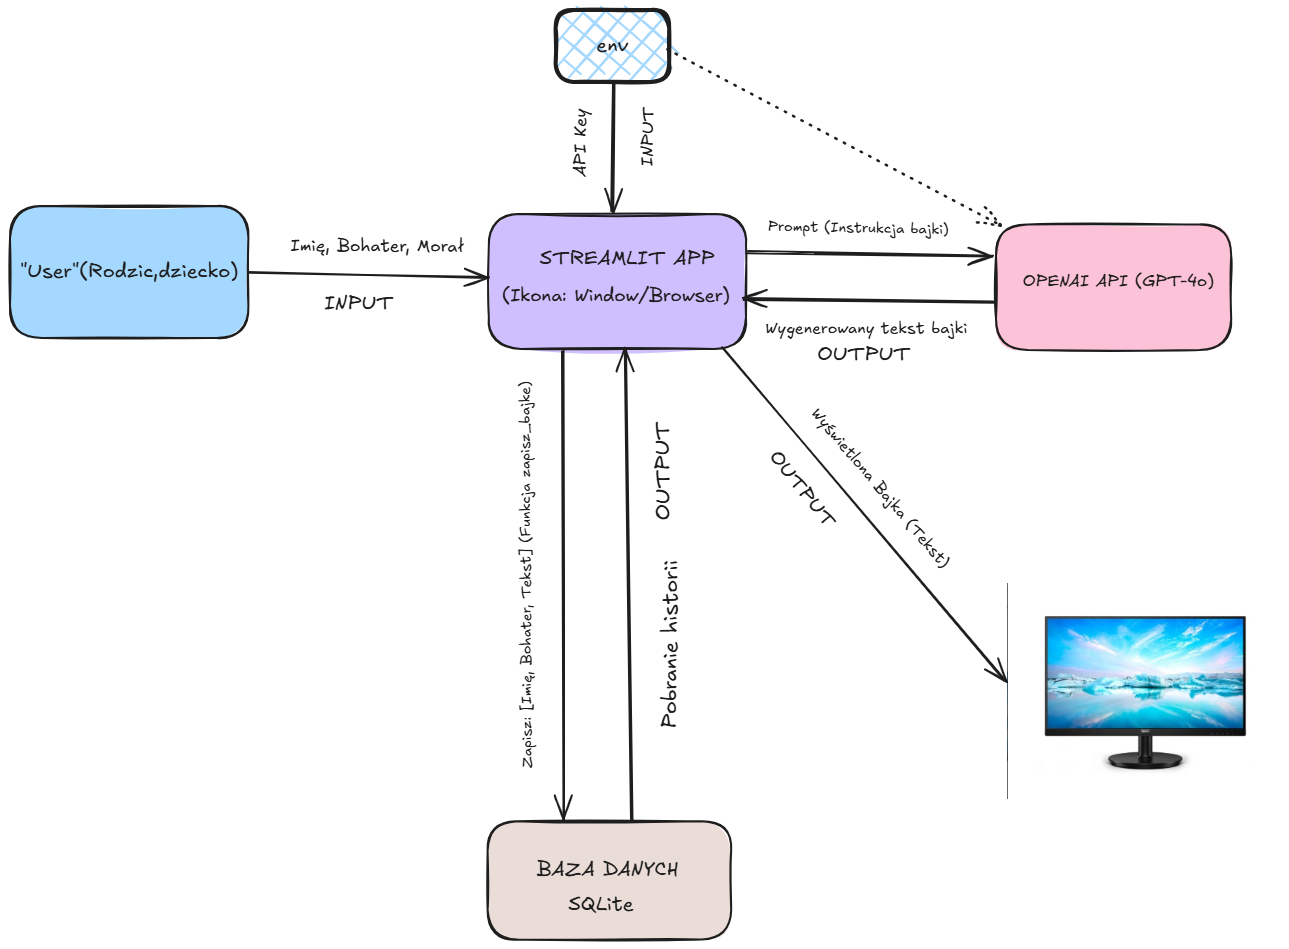

# "Proof of Concept" (dowód działania) #

In [16]:
import warnings
import logging
import os
import sys

# 1. Całkowite wyciszenie loggera Streamlit
logging.getLogger("streamlit").setLevel(logging.ERROR)

# 2. Blokada komunikatów systemowych (stderr)
sys.stderr = open(os.devnull, 'w')

# 3. Magia Jupytera (ukrywa wyjście komórki)
from IPython.display import clear_output
clear_output()

In [9]:
import streamlit as st
import sqlite3
import os
from dotenv import load_dotenv
from openai import OpenAI

In [10]:
load_dotenv() 
client = OpenAI()

def inicjalizuj_baze():
    """Tworzy lokalną bazę danych SQLite dla bajek."""
    conn = sqlite3.connect('bajki_dzieci.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS historie (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            imie_dziecka TEXT,
            bohater TEXT,
            tresc_bajki TEXT,
            url_obrazka TEXT
        )
    ''')
    conn.commit()
    conn.close()

In [11]:
def generuj_bajke(imie, bohater, moral):
    """Wykorzystuje model GPT-4o do stworzenia opowieści."""
    prompt = f"Napisz magiczną bajkę dla dziecka o imieniu {imie}. Bohater: {bohater}. Morał: {moral}."
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Jesteś ciepłym opowiadaczem bajek dla dzieci."},
            {"role": "user", "content": prompt}
        ]
    )
    
    # 2. POPRAWKA: [0].message.content (zgodnie z najnowszą wersją biblioteki)
    return response.choices[0].message.content

In [12]:
def zapisz_bajke(imie, bohater, tresc):
    """Zapisuje wynik pracy AI do bazy danych."""
    conn = sqlite3.connect('bajki_dzieci.db')
    cursor = conn.cursor()
    cursor.execute('INSERT INTO historie (imie_dziecka, bohater, tresc_bajki) VALUES (?, ?, ?)', 
                   (imie, bohater, tresc))
    conn.commit()
    conn.close()

In [13]:
st.title ("Generator Bajek dla Dzieci")

DeltaGenerator()

In [14]:
inicjalizuj_baze()

# Pola do wprowadzania danych przez użytkownika
imie_dz = st.text_input("Imię dziecka:", "Kacper")
postac = st.text_input("Główny bohater:", "Złoty Smok")
temat = st.text_area("O czym ma być bajka? (morał):", "dlaczego warto dzielić się zabawkami")

In [15]:
if st.button("Wygeneruj i zapisz bajkę ✨"):
    try:
        with st.spinner('Piszę bajkę... proszę czekać.'):
            wynik_bajki = generuj_bajke(imie_dz, postac, temat)
            
            # Wyświetlanie w aplikacji
            st.subheader(f"Oto bajka dla {imie_dz}:")
            st.write(wynik_bajki)
            
            # Zapisywanie
            zapisz_bajke(imie_dz, postac, wynik_bajki)
            st.success("✅ Bajka została zapisana w bazie danych!")
            
    except Exception as e:
        st.error(f"❌ Błąd: {e}")
        


### 🔄 Aktualizacja techniczna: Integracja z Qdrant Cloud
W toku prac nad aplikacją rozwiązano kluczowe problemy z łącznością i bezpieczeństwem:

* **Rozwiązanie błędu gRPC/DLL:** Zastąpienie `qdrant-client` żądaniami przez bibliotekę `requests`. Zapewnia to stabilność na Windows i w chmurze bez konieczności walki z uprawnieniami systemowymi.
* **Wdrożenie Embeddingów:** Implementacja modelu `text-embedding-3-small` (1536 wymiarów), który w czasie rzeczywistym zamienia bajkę na wektor i wysyła ją do [Qdrant Cloud](https://qdrant.tech).
* **Migracja Secrets:** Przejście na [Streamlit Secrets](https://docs.streamlit.io), co pozwala na bezpieczne udostępnienie projektu na GitHubie bez ryzyka wycieku kluczy API.